In [21]:
import gym
import gym_jumping_task
from gym_jumping_task.envs.jumping_task import JumpTaskEnv
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid
import torch.nn as nn
import augmentations
import torchvision.transforms.functional as fn

In [22]:
device = torch.device('cpu')

env = JumpTaskEnv(scr_w=60, scr_h=60)
observation = env._reset(floor_height=30, obstacle_position=30)
print(observation.shape)

(60, 60)


Done! Episode Reward:  24


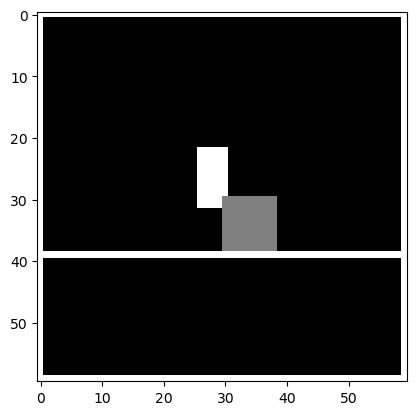

In [23]:
done = False
rewards = []
frames = []

state = env.reset()
while not done:
    action = np.random.randint(low=0, high=2)
    next_state, r, done, info = env.step(action)
    rewards.append(r)
    frames.append(np.flipud(state))
    state = next_state
    if done: 
        print("Done! Episode Reward: ", np.sum(rewards))
        plt.imshow(np.flipud(state), cmap='gray', vmin=0, vmax=1)
        break

# Augmentations

In [24]:
# convert the frames from [0., 1.] to [0, 255]
frames = np.array(np.array(frames) * 255, dtype=np.uint8)
# Convert the frame stack into the correct format (B, C, H, W)
if len(frames.shape) == 3: frames = np.expand_dims(frames, axis=1)


print(frames.shape)
print(frames.dtype)

(26, 1, 60, 60)
uint8


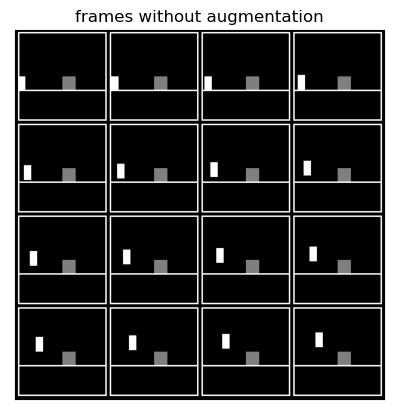

In [25]:
def show_imgs(x,max_display=16, title:str = ""):
    grid = make_grid(torch.from_numpy(x[:max_display]),4).permute(1,2,0).cpu().numpy()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(grid)
    if len(title) > 0: plt.title(title)
    plt.show()

show_imgs(frames, title="frames without augmentation")

(26, 1, 70, 70)


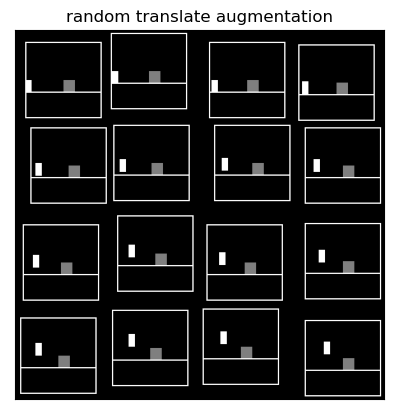

In [26]:
rnd_trans = augmentations.random_translate(frames,70)
print(rnd_trans.shape)
show_imgs(rnd_trans, title="random translate augmentation")

(26, 1, 60, 60)


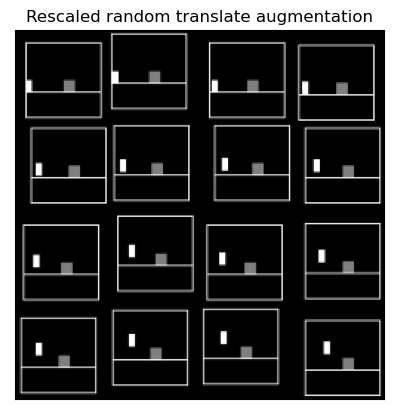

In [27]:
# Try to rescale images to 60x60
rnd_trans = fn.resize(torch.from_numpy(rnd_trans), size=[60,60]).numpy()
print(rnd_trans.shape)
show_imgs(rnd_trans, title="Rescaled random translate augmentation")

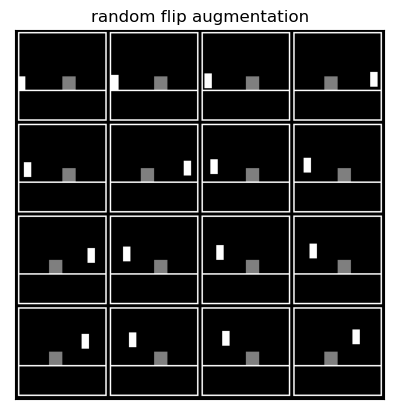

In [16]:
flipped_x = augmentations.random_flip(frames)
show_imgs(flipped_x, title="random flip augmentation")

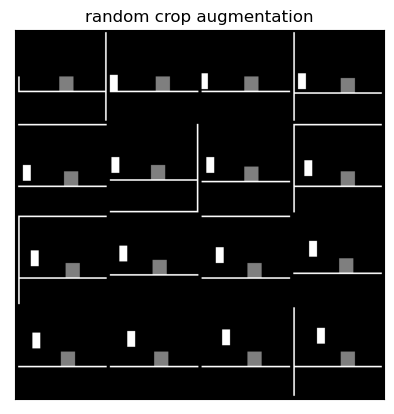

In [17]:
cropped_x = augmentations.random_crop(frames,56)
show_imgs(cropped_x, title="random crop augmentation")

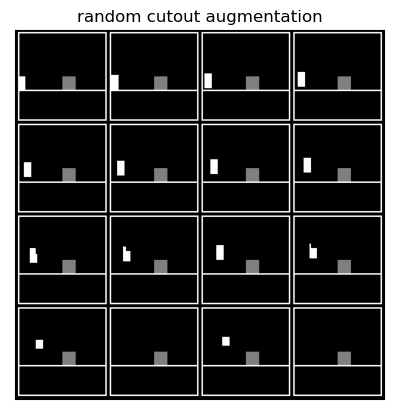

In [18]:
cut_x = augmentations.random_cutout(frames,10,15)
show_imgs(cut_x, title="random cutout augmentation")

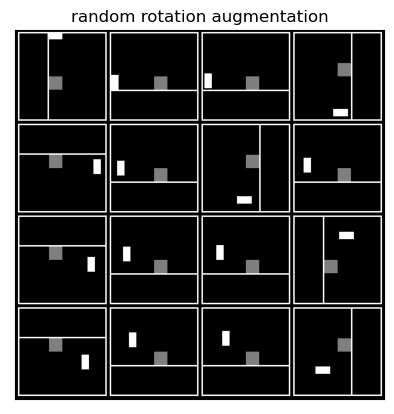

In [19]:
rnd_rotation = augmentations.random_rotation(frames,device)
show_imgs(rnd_rotation, title="random rotation augmentation")